# Insurance Classifier Notebook

This notebook implements an insurance classification system that categorizes companies based on their descriptions using multiple NLP techniques.

Data Exploration and Analysis

Before building our classifier, let's analyze the dataset to understand its characteristics:

1. **Sector Distribution**:
   - Shows the distribution of companies across different insurance sectors
   - Helps identify class imbalance and data distribution
   - Informs our classification strategy and threshold selection

2. **Text Length Analysis**:
   - Analyzes the distribution of words per sample
   - Helps determine appropriate sequence lengths for our models
   - Influences our feature processing decisions


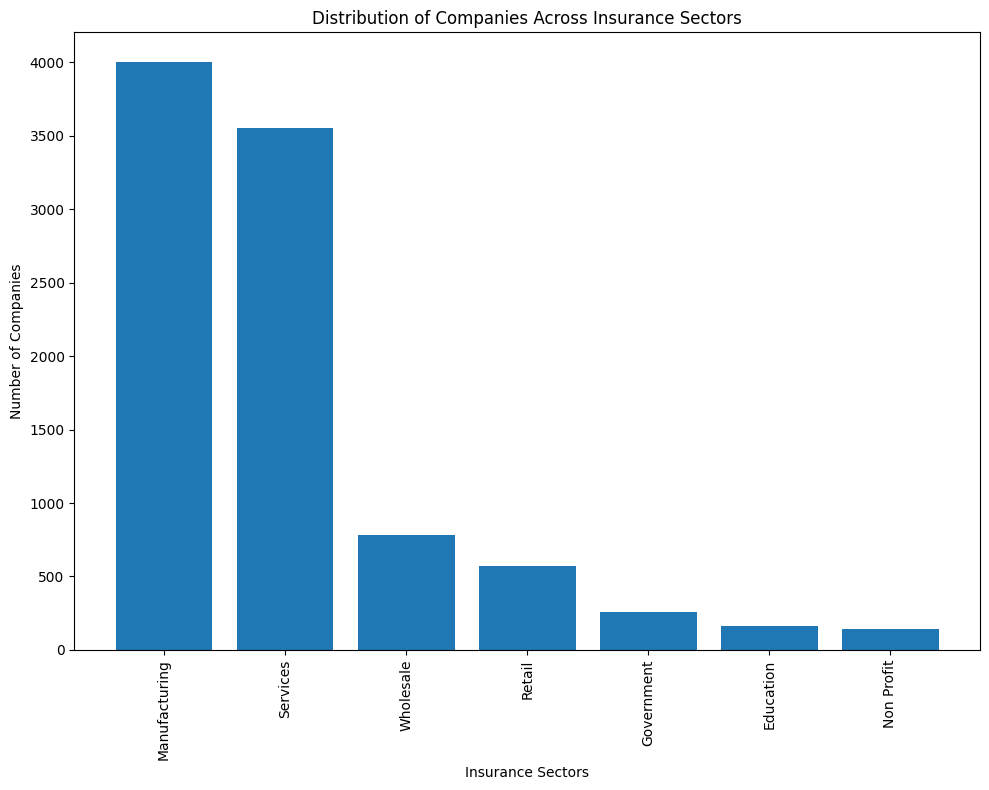

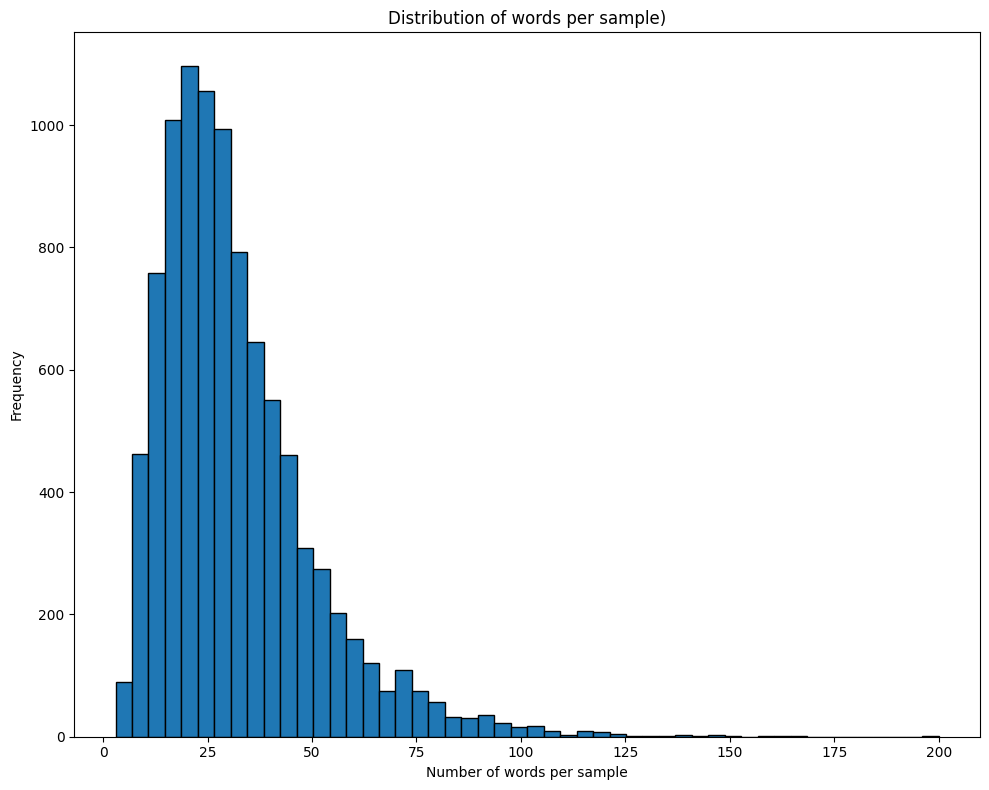

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df_companies = pd.read_csv('ml_insurance_challenge.csv')

# Plot sector distribution
plt.figure(figsize=(10, 8))
sector_counts = df_companies['sector'].value_counts()
plt.bar(sector_counts.index, sector_counts.values)
plt.xlabel('Insurance Sectors')
plt.ylabel('Number of Companies')
plt.title('Distribution of Companies Across Insurance Sectors')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Calculate and plot text length distribution
samples_len = []
cols = ['business_tags', 'category', 'niche']
for chunk in pd.read_csv('ml_insurance_challenge.csv', usecols=cols, chunksize=1):
    words_no = 0
    tags = chunk['business_tags'].values[0]
    category = chunk['category'].values[0]
    niche = chunk['niche'].values[0]

    if pd.notna(tags):
        words_no += len(tags.split(' '))

    if pd.notna(category):
        words_no += len(category.split(' '))

    if pd.notna(niche):
        words_no += len(niche.split(' '))

    samples_len.append(words_no)


plt.figure(figsize=(10, 8))
plt.hist(samples_len, bins=50, edgecolor='black', density=False)
plt.ylabel('Frequency')
plt.xlabel('Number of words per sample')
plt.title(f'Distribution of words per sample)')
plt.tight_layout()
plt.show()

## 1. Import Required Libraries

First, we import all necessary Python libraries for data processing, machine learning, and deep learning. This includes:
- Pandas for data manipulation
- Scikit-learn for traditional ML models
- PyTorch for neural networks
- SentenceTransformers for text embeddings
- Logging for tracking progress

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
from typing import List
import logging
import re
from sklearn.metrics.pairwise import cosine_similarity

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## 2. Main InsuranceClassifier Class

This is the core class that implements the insurance classification system. It:
- Loads the taxonomy of insurance categories
- Initializes multiple models (sentence transformer, MLP, SepCNN)
- Sets up TF-IDF vectorizer to create more reliable scores for present expressions/words
- Handles GPU acceleration if available

Further, an instance of the classifier is created with a similarity threshold of 0.85 (less will generate false pozitives).

In [6]:
class InsuranceClassifier:
    def __init__(self, taxonomy_path: str, similarity_threshold: float = 0.8):
        self.taxonomy_df = pd.read_csv(taxonomy_path)
        self.taxonomy_labels = self.taxonomy_df['label'].tolist()
        self.num_classes = len(self.taxonomy_labels)
        self.similarity_threshold = similarity_threshold
        
        # Initialize models for quantifying the similarity between the company description and the taxonomy labels
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.mlp_model = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500)
        
        # Initialize vectorizers
        self.tfidf_vectorizer = TfidfVectorizer(
            ngram_range=(2, 3),  # Bigrams AND Trigrams for more accuracy
            min_df=2,
            max_df=0.95,
            stop_words='english'
        )
        
        # Pre-compute taxonomy embeddings
        self.taxonomy_embeddings = self.sentence_model.encode(self.taxonomy_labels)
        logger.info(f"Loaded {len(self.taxonomy_labels)} taxonomy labels")

# Initialize classifier with similarity threshold
classifier = InsuranceClassifier('insurance_taxonomy.csv', similarity_threshold=0.85)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 7/7 [00:00<00:00, 17.57it/s]
INFO:__main__:Loaded 220 taxonomy labels


## 3. Similarity Matching Functions

1. **Embedding Generation**:
   - Uses `all-MiniLM-L6-v2` sentence transformer to convert text into 768-dimensional vectors
   - Pre-computes embeddings for all taxonomy labels for efficiency
   - Generates embeddings for company descriptions on-the-fly

2. **Similarity Calculation**:
   - Uses cosine similarity to measure semantic closeness between vectors
   - Cosine similarity is preferred over Euclidean distance for text because:
     - It's scale-invariant (focuses on angle between vectors)
     - Better captures semantic similarity regardless of text length
     - Ranges from -1 to 1, where 1 means identical meaning

3. **Threshold-based Matching**:
   - Default threshold of 0.85 to ensure high-quality matches
   - Higher threshold reduces false positives but may miss some valid categories
   - Lower threshold increases recall but may introduce noise

4. **Fallback Mechanism**:
   - If no matches meet the threshold, returns top 3 most similar categories
   - Ensures every company gets at least some classification
   - Helps handle edge cases and ambiguous descriptions

In [7]:
def get_similar_labels(InsuranceClassifier, text_embedding: np.ndarray) -> List[str]:
    # Calculate similarities with all taxonomy labels which are above threshold
    similarities = cosine_similarity([text_embedding], InsuranceClassifier.taxonomy_embeddings)[0]
    
    # Get indices of labels with similarity above threshold
    similar_indices = np.where(similarities >= InsuranceClassifier.similarity_threshold)[0]
    
    # Get the corresponding labels
    similar_labels = [InsuranceClassifier.taxonomy_labels[i] for i in similar_indices]
    
    # If no labels meet the threshold, get the top 3 most similar
    if not similar_labels:
        top_indices = np.argsort(similarities)[-3:]  # Get top 3 most similar
        similar_labels = [InsuranceClassifier.taxonomy_labels[i] for i in top_indices]
        logger.debug(f"No labels above threshold {InsuranceClassifier.similarity_threshold}, using top 3: {similar_labels}")
    
    return similar_labels

## 4. Text Processing Utilities
 
Basic text processing methods:
- `tokenize` is used for splitting text into words or characters
- `clean_text` is used for normalization (lowercase, remove numbers/punctuation)
- `prepare_data` it combines multiple text fields into one clean string. It writes it in a new column in the CSV file in order to use less memory


In [8]:
def tokenize(text: str, mode: str = 'word') -> List[str]:
    if mode == 'word':
        return text.split()
    return list(text)

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    return ' '.join(text.split())

def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['combined_text'] = (
        df['description'].fillna('') + ' ' +
        df['business_tags'].fillna('') + ' ' +
        df['category'].fillna('') + ' ' +
        df['niche'].fillna('')
    ).apply(clean_text)
    return df

## 5. Feature Processing Methods

1. **N-gram Path (TF-IDF based)**:
   - Uses bigrams and trigrams (`ngram_range=(2, 3)`)
   - TF-IDF weighting:
     - Downweights common terms across all documents
     - Helps identify industry-specific language

2. **Sequence Path (Embedding based)**:
   - Leverages pre-trained sentence embeddings
   - Captures semantic meaning and context
   - Preserves word order and relationships
   - Better for understanding complex descriptions

3. **Feature Selection**:
   - `select_top_k_features` with two modes:
     - Score-based: Selects features with highest TF-IDF scores
     - Frequency-based: Chooses most commonly occurring terms
   - Improves model efficiency and generalization

4. **Normalization Options**:
   - Sample-wise: Normalizes each document independently
   - Feature-wise: Normalizes across all documents

In [9]:
def select_top_k_features(features: np.ndarray, k: int, mode: str = 'score') -> np.ndarray:
    if mode == 'score':
        scores = np.sum(features, axis=0)
        top_indices = np.argsort(scores)[-k:]
        return features[:, top_indices]
    else:  # freq mode
        freq = np.sum(features > 0, axis=0)
        top_indices = np.argsort(freq)[-k:]
        return features[:, top_indices]

def normalize_features(features: np.ndarray, mode: str = 'None') -> np.ndarray:
    if mode == 'samplewise':
        return normalize(features, norm='l2', axis=1)
    elif mode == 'featurewise':
        return normalize(features, norm='l2', axis=0)
    return features

def process_ngram_path(texts: List[str], top_k: int = 20000) -> np.ndarray:
    # TF-IDF vectorization with bigrams
    features = InsuranceClassifier.tfidf_vectorizer.fit_transform(texts).toarray()
    
    # Select top k features using f_classif scoring
    features = select_top_k_features(features, min(top_k, features.shape[1]), mode='score')
    return features

def process_sequence_path(texts: List[str], top_k: int = 20000) -> np.ndarray:
    # Get embeddings
    embeddings = InsuranceClassifier.sentence_model.encode(texts)
    
    # Select top k features using frequency
    embeddings = select_top_k_features(embeddings, min(top_k, embeddings.shape[1]), mode='freq')
    return embeddings

## 6. Classification and Evaluation
 
**Company Classification (`classify_companies`)**:
   - Processes company data through multiple stages:
     - Text preparation and cleaning
     - Embedding generation using sentence transformer
     - Similarity matching with taxonomy labels
     - Threshold-based assignment (default 0.85)
     - Fallback to top 3 matches if needed
   - Includes progress tracking and example logging


In [10]:
def classify_companies(ic: InsuranceClassifier, df: pd.DataFrame) -> pd.DataFrame:
    df = prepare_data(df)
    texts = df['combined_text'].tolist()
    
    # Get embeddings for all texts
    logger.info("Computing embeddings for company descriptions...")
    text_embeddings = ic.sentence_model.encode(texts)
    
    # Get similar labels for each text
    logger.info("Finding similar taxonomy labels...")
    all_labels = []
    for i, embedding in enumerate(text_embeddings):
        similar_labels = get_similar_labels(ic, embedding)
        all_labels.append(', '.join(similar_labels))
        
        # Log progress every 100 companies
        if (i + 1) % 100 == 0:
            logger.info(f"Processed {i + 1}/{len(texts)} companies")
    
    df['insurance_label'] = all_labels
    
    # Log some examples
    logger.info("\nExample classifications:")
    for i in range(min(5, len(df))):
        logger.info(f"\nCompany: {df.iloc[i]['description'][:100]}...")
        logger.info(f"Assigned labels: {df.iloc[i]['insurance_label']}")
    
    return df

# Classify companies
df_classified = classify_companies(classifier, df_companies)

df_classified = df_classified.drop(columns=['combined_text']) # Drop intermediate column
df_classified.to_csv('classified_companies.csv', index=False)

INFO:__main__:Computing embeddings for company descriptions...
Batches: 100%|██████████| 297/297 [00:29<00:00,  9.95it/s]
INFO:__main__:Finding similar taxonomy labels...
INFO:__main__:Processed 100/9494 companies
INFO:__main__:Processed 200/9494 companies
INFO:__main__:Processed 300/9494 companies
INFO:__main__:Processed 400/9494 companies
INFO:__main__:Processed 500/9494 companies
INFO:__main__:Processed 600/9494 companies
INFO:__main__:Processed 700/9494 companies
INFO:__main__:Processed 800/9494 companies
INFO:__main__:Processed 900/9494 companies
INFO:__main__:Processed 1000/9494 companies
INFO:__main__:Processed 1100/9494 companies
INFO:__main__:Processed 1200/9494 companies
INFO:__main__:Processed 1300/9494 companies
INFO:__main__:Processed 1400/9494 companies
INFO:__main__:Processed 1500/9494 companies
INFO:__main__:Processed 1600/9494 companies
INFO:__main__:Processed 1700/9494 companies
INFO:__main__:Processed 1800/9494 companies
INFO:__main__:Processed 1900/9494 companies
IN